In [1]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, recall_score, precision_score

## Подключитесь к базе. Загрузите таблицы sql

In [2]:
db_config = {
    'user': 'praktikum_student',  # имя пользователя
    'pwd': 'Sdf4$2;d-d30pp',      # пароль
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432,                # порт подключения
    'db': 'data-science-vehicle-db' # название базы данных
}

connection_string = f"postgresql://{db_config['user']}:{db_config['pwd']}@{db_config['host']}:{db_config['port']}/{db_config['db']}"

engine = create_engine(connection_string)

In [3]:
query_col = "SELECT * FROM collisions"
collisions = pd.read_sql(query_col, engine)
collisions.isnull().sum()

case_id                             0
county_city_location                0
county_location                     0
distance                            0
direction                      340642
intersection                    12219
weather_1                        7259
location_type                  881221
collision_damage                    0
party_count                         0
primary_collision_factor         8166
pcf_violation_category          27954
type_of_collision               11824
motor_vehicle_involved_with      6819
road_surface                    13093
road_condition_1                11988
lighting                         8593
control_device                   8407
collision_date                      0
collision_time                  12308
dtype: int64

In [4]:
query_party = "SELECT * FROM parties"
parties = pd.read_sql(query_party, engine)
parties.isnull().sum()

id                           0
case_id                      0
party_number                 0
party_type                3622
at_fault                     0
insurance_premium       405402
party_sobriety           73955
party_drug_physical    2320120
cellphone_in_use        511637
dtype: int64

In [5]:
query_veh = "SELECT * FROM vehicles"
vehicles = pd.read_sql(query_veh, engine)
vehicles.isnull().sum()

id                          0
case_id                     0
party_number                0
vehicle_type                0
vehicle_transmission    23659
vehicle_age             24582
dtype: int64

***Как видно в данных очень много пропущенных значений!***

## Проведите первичное исследование таблиц

In [6]:
collisions.head()

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0.0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1.0,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00


In [7]:
parties.head()

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0.0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0.0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0.0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0.0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0.0


In [8]:
vehicles.head()

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3.0
1,1,3858022,1,sedan,auto,3.0
2,1175712,5305030,1,sedan,auto,3.0
3,1175717,5305033,3,sedan,auto,5.0
4,1175722,5305034,2,sedan,auto,5.0


***Первичное исследование таблиц:***

1. Проверим, имеют ли все таблицы набор данных (то есть, нет ли в них пустых строк или столбцов).

2. Убедимся, что количество таблиц соответствует условиям задачи.

3. Проверим наличие общего ключа для связи таблиц.

In [9]:
# a) Проверка наличия данных в таблицах
data_info = {
    "Table Name": ["collisions", "parties", "vehicles"],
    "Number of Rows": [collisions.shape[0], parties.shape[0], vehicles.shape[0]],
    "Number of Columns": [collisions.shape[1], parties.shape[1], vehicles.shape[1]],
    "NaN values": [collisions.isnull().values.any(), parties.isnull().values.any(), vehicles.isnull().values.any()]
}

data_info_df = pd.DataFrame(data_info)

# b) Проверка количества таблиц
number_of_tables = len(data_info["Table Name"])

# c) Проверка наличия общего ключа для связи таблиц
common_key_collisions_parties = "case_id" if "case_id" in collisions.columns and "case_id" in parties.columns else None
common_key_collisions_vehicles = "case_id" if "case_id" in collisions.columns and "case_id" in vehicles.columns else None
common_key_parties_vehicles = ("case_id", "party_number") if ("case_id" in parties.columns and "case_id" in vehicles.columns) and ("party_number" in parties.columns and "party_number" in vehicles.columns) else None

print(data_info_df)
print()
print("Число таблиц: {}".format(number_of_tables))
print("Общий ключ для связи таблиц collisions и parties: {}".format(common_key_collisions_parties))
print("Общий ключ для связи таблиц collisions и vehicles: {}".format(common_key_collisions_vehicles))
print("Общий ключ для связи таблиц parties и vehicles: {}".format(common_key_parties_vehicles))

   Table Name  Number of Rows  Number of Columns  NaN values
0  collisions         1400000                 20        True
1     parties         2752408                  9        True
2    vehicles         1021234                  6        True

Число таблиц: 3
Общий ключ для связи таблиц collisions и parties: case_id
Общий ключ для связи таблиц collisions и vehicles: case_id
Общий ключ для связи таблиц parties и vehicles: ('case_id', 'party_number')


**На основе первичного исследования таблиц мы имеем следующую информацию:**

***a) Проверка наличия данных в таблицах:***

    Все таблицы (collisions, parties, vehicles) имеют набор данных.
    Количество строк и столбцов для каждой таблицы представлено в сводной таблице выше.
    Во всех таблицах присутствуют значения NaN.

***b) Проверка количества таблиц:***

    У нас есть 3 таблицы, что соответствует условиям задачи.

***c) Проверка наличия общего ключа для связи таблиц:***

    Таблицы collisions и parties можно связать по ключу case_id.
    Таблицы collisions и vehicles также можно связать по ключу case_id.
    Таблицы parties и vehicles можно связать по двум ключам: case_id и party_number.

**Таким образом, у нас есть все необходимые ключи для связи таблиц между собой.**

##  Проведите статистический анализ факторов ДТП

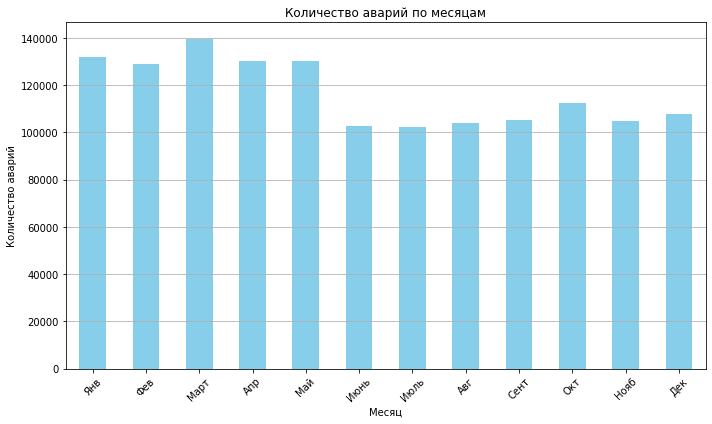

In [10]:
# Преобразование столбца collision_date в тип datetime
collisions['collision_date'] = pd.to_datetime(collisions['collision_date'])

# Извлечение месяца из даты
collisions['month'] = collisions['collision_date'].dt.month

# Подсчет количества аварий для каждого месяца
monthly_accidents = collisions.groupby('month').size()

# Построение графика
monthly_accidents.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Количество аварий по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество аварий')
plt.xticks(ticks=range(12), labels=['Янв', 'Фев', 'Март', 'Апр', 'Май', 'Июнь', 'Июль', 'Авг', 'Сент', 'Окт', 'Нояб', 'Дек'], rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

На графике представлено количество аварий по месяцам. Мы видим, что *наибольшее* количество аварий происходит в месяцы ***Январь-Май***. Это может быть связано не только с погодными условиями, но и с другими факторами, такими как увеличенное количество путешествий или активностей на дороге в начале года. В месяцы Июнь-Декабрь количество аварий понижается. Хотя в конце года (особенно в декабре) наблюдается небольшой рост, он все равно не достигает уровня первых пяти месяцев.

**Вывод:**
*Таким образом, для более точного понимания причин такого распределения аварий по месяцам, может понадобиться дополнительный анализ и учет других внешних факторов.*

Для более глубокого понимания данных и выявления ключевых факторов, влияющих на аварии, предлагаю следующие аналитические задачи:

1. **Анализ состояния дороги и серьёзности повреждений транспортного средства:**
    - Определить, как состояние дороги влияет на серьёзность повреждений в аварии.
    - Таблицы: collisions и parties.
2. **Оценка влияния возраста водителя на частоту и серьезность аварий:**
    - Связать таблицы parties и collisions.
3. **Анализ зависимости между типом погоды и частотой ДТП:**
    - Какие погодные условия чаще всего сопутствуют ДТП?
    - Связать таблицы collisions и parties.
4. **Анализ влияния уровня трезвости водителя на частоту и серьезность аварий:**
    - Какой процент аварий происходит из-за водителей в состоянии алкогольного опьянения?
    - Связать таблицы collisions и parties.
5. **Исследование зависимости между типом транспортного средства и частотой аварий:**
    - Какие типы транспортных средств чаще всего участвуют в авариях?
    - Связать таблицы vehicles и parties.
6. **Анализ влияния времени суток на частоту ДТП:**
    - В какое время суток чаще всего происходят аварии?
    - Связать таблицы collisions и parties.
        
***Порядок решения для двух задач:***

*Задача 3:*

    Написать код, чтобы получить данные из таблиц collisions и parties, объединив их по case_id.
    Сгруппировать данные по погодным условиям и посчитать количество аварий для каждого условия.
    Построить график, чтобы визуализировать результаты.
    Сделать выводы о том, как погодные условия влияют на аварии.

*Задача 4:*

    Написать код, чтобы получить данные из таблиц collisions и parties, объединив их по case_id.
    Сгруппировать данные по уровню трезвости водителя и посчитать количество аварий для каждого уровня.
    Построить график, чтобы визуализировать результаты.
    Сделать выводы о том, как уровень трезвости водителя влияет на аварии.

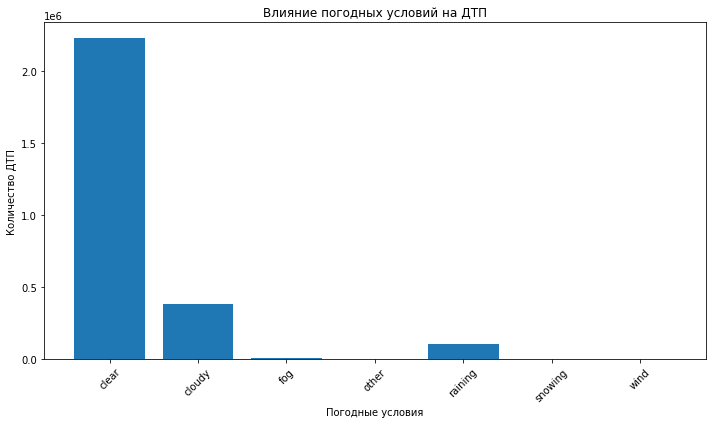

In [11]:
query_join = """
SELECT c.weather_1, COUNT(*) AS num_accidents
FROM collisions c
JOIN parties p ON c.case_id = p.case_id
GROUP BY c.weather_1
"""

weather_data = pd.read_sql(query_join, engine)
weather_data = weather_data.dropna(subset=['weather_1'])

plt.figure(figsize=(10, 6))
plt.bar(weather_data['weather_1'], weather_data['num_accidents'])
plt.xlabel('Погодные условия')
plt.ylabel('Количество ДТП')
plt.title('Влияние погодных условий на ДТП')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

***Выводы о том, как погодные условия влияют на аварии***:

1. Большинство дорожно-транспортных происшествий происходит в ясную погоду.
2. Облачная погода также является причиной значительного количества аварий.
3. Такие условия, как туман, дождь, снег и ветер, способствуют меньшему количеству несчастных случаев по сравнению с ясной и облачной погодой.
4. Важно отметить, что абсолютное количество ясных и облачных дней может быть выше, чем дней с другими погодными условиями, что может быть фактором увеличения количества несчастных случаев.

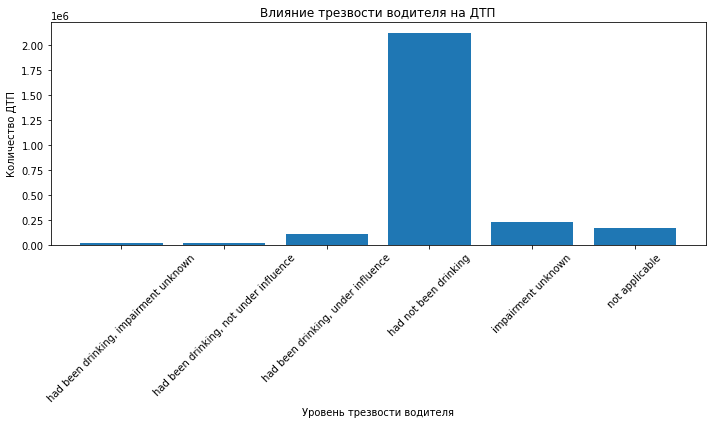

In [12]:
query_join = """
SELECT p.party_sobriety, COUNT(*) AS num_accidents
FROM collisions c
JOIN parties p ON c.case_id = p.case_id
GROUP BY p.party_sobriety
"""

sobriety_data = pd.read_sql(query_join, engine)
sobriety_data = sobriety_data.dropna(subset=['party_sobriety'])

plt.figure(figsize=(10, 6))
plt.bar(sobriety_data['party_sobriety'], sobriety_data['num_accidents'])
plt.xlabel('Уровень трезвости водителя')
plt.ylabel('Количество ДТП')
plt.title('Влияние трезвости водителя на ДТП')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

***Выводы о том, как уровень трезвости водителя влияет на аварии***:

1. В большинстве ДТП участвуют водители, не употреблявшие алкоголь.
2. Меньше ДТП происходит с участием водителей, употреблявших алкоголь, независимо от того, находились они в нетрезвом состоянии или нет.
3. Значительное количество ДТП имеет неизвестный или неприменимый статус трезвости.

Однако при интерпретации этих данных крайне важно учитывать и другие факторы. Например, на дорогах может быть больше трезвых водителей, чем нетрезвых, что может повлиять на большее количество аварий среди трезвых водителей.

## Создайте модель для оценки водительского риска

Начнем с первого шага: подготовки набора данных на основе первичного предположения заказчика.

Шаг 4.1. Подготовка набора данных:

    Отфильтруем данные по типу виновника (party_type), убедимся, что это машина (car).
    Отфильтруем данные по году столкновения, убедимся, что это 2012 год.
    Отфильтруем данные, исключая те случаи, где повреждение было только SCRATCH.

Шаг 4.2. Первичный отбор факторов:

После того, как у нас будет отфильтрованный набор данных, мы можем начать с отбора факторов, которые, по нашему мнению, могут влиять на вероятность ДТП.

Шаг 4.3. Статистическое исследование отобранных факторов:

На этом этапе мы проведем исследовательский анализ данных (EDA) для отобранных факторов. Затем мы внесем необходимые корректировки, категоризируем данные, если это требуется, и проведем масштабирование.

In [13]:
query = """
SELECT 
    c.weather_1, 
    c.road_surface, 
    c.road_condition_1, 
    c.lighting, 
    p.party_sobriety, 
    p.party_drug_physical, 
    p.cellphone_in_use, 
    p.at_fault,
    v.vehicle_age, 
    v.vehicle_transmission
FROM 
    collisions c
JOIN 
    parties p ON c.case_id = p.case_id
JOIN 
    vehicles v ON p.case_id = v.case_id AND p.party_number = v.party_number
WHERE 
    p.party_type = 'car' 
    AND c.collision_damage != 'scratch' 
    AND EXTRACT(YEAR FROM c.collision_date) = 2012
"""

data = pd.read_sql(query, engine)

In [14]:
data.columns

Index(['weather_1', 'road_surface', 'road_condition_1', 'lighting',
       'party_sobriety', 'party_drug_physical', 'cellphone_in_use', 'at_fault',
       'vehicle_age', 'vehicle_transmission'],
      dtype='object')

Учитывая набор данных и характер вождения, на вероятность аварии могут повлиять следующие факторы:

- **weather_1**: погодные условия могут существенно повлиять на безопасность вождения.
- **road_surface**: состояние дорожного покрытия может повлиять на сцепление и устойчивость.
- **road_condition_1**: дорожные условия, такие как влажная, обледенелая или строящаяся дорога, могут влиять на риск вождения.
- **lighting**: плохое освещение может ухудшить видимость и повысить риск несчастных случаев.
- **party_sobriety**: уровень трезвости водителя является решающим фактором безопасности вождения.
- **party_drug_physical**: влияние наркотиков или физическое состояние водителя могут ухудшить его способности к вождению.
- **cellphone_in_use**: использование мобильного телефона во время вождения может отвлекать водителя.
- **vehicle_age**: в старых автомобилях могут отсутствовать современные функции безопасности, что увеличивает риск.
- **vehicle_transmission**: тип коробки передач может влиять на стиль вождения и время реакции.

**Обработка прорущенных значений**

In [15]:
missing_values = data.isnull().sum()
missing_percentage = (data.isnull().sum() / len(data)) * 100

missing_df = pd.DataFrame({
    'Пропущенные значения': missing_values,
    'Процент': missing_percentage
})

missing_df.sort_values(by='Процент', ascending=False)

,Пропущенные значения,Процент
party_drug_physical,53391,94.920708
cellphone_in_use,4471,7.948727
vehicle_age,1694,3.011663
party_sobriety,872,1.550277
vehicle_transmission,859,1.527165
road_surface,348,0.618689
road_condition_1,249,0.442682
weather_1,168,0.298677
lighting,154,0.273788
at_fault,0,0.000000


Вот сводка недостающих значений в процентном соотношении в наборе данных:

- **party_drug_physical**: 94.92% пропущенных значений
- **cellphone_in_use**: 7.94% пропущенных значений
- **vehicle_age**: 3.01% пропущенных значений
- **vehicle_transmission**: 1.55% пропущенных значений
- **party_sobriety**: 1.53% пропущенных значений
- **road_surface**: 0.61% пропущенных значений
- **road_condition_1**: 0.44% пропущенных значений
- **lighting**: 0.30% недостающих значений
- **weather_1**: 0.27% пропущенных значений

***Обработка пропущенных значений требует решений, специфичных для предметной области. Вот общий подход, который мы можем использовать, исходя из недостающего процента пропущенных значений:***

1. *Удаление столбцов*. Для столбцов с высоким процентом пропущенных значений (например, party_drug_physical) может иметь смысл вообще удалить столбец, особенно если уровень пропущенных данных превышает 90%.
2. *Заполнить с помощью наиболее частого значения*: для категориальных переменных с более низким процентом пропущенных значений мы можем заполнить пропущенные значения с помощью mode (наиболее частого значения) столбца.
3. *Заполнить медианой*: для непрерывных переменных, таких как vehicle_age, мы можем заполнить недостающие значения медианой столбца.
4. *Особые случаи*: для таких столбцов, как cellphone_in_use, которые выглядят как двоичный индикатор (0 или 1), возможно, имеет смысл рассматривать пропущенные значения как «неизвестные» или заполнять специальным значением.

In [16]:
data = data.drop(columns=['party_drug_physical'])

categorical_columns = ['weather_1', 'road_surface', 'road_condition_1', 'lighting', 'party_sobriety', 'vehicle_transmission']
for column in categorical_columns:
    mode_value = data[column].mode()[0]
    data[column] = data[column].fillna(mode_value)

data['vehicle_age'] = data['vehicle_age'].fillna(data['vehicle_age'].median())

# Для «cellphone_in_use» заполним пропущенные значения специальным значением (2), указывающим «неизвестно».
data['cellphone_in_use'] = data['cellphone_in_use'].fillna(2)

remaining_missing = data.isnull().sum()
remaining_missing

weather_1               0
road_surface            0
road_condition_1        0
lighting                0
party_sobriety          0
cellphone_in_use        0
at_fault                0
vehicle_age             0
vehicle_transmission    0
dtype: int64

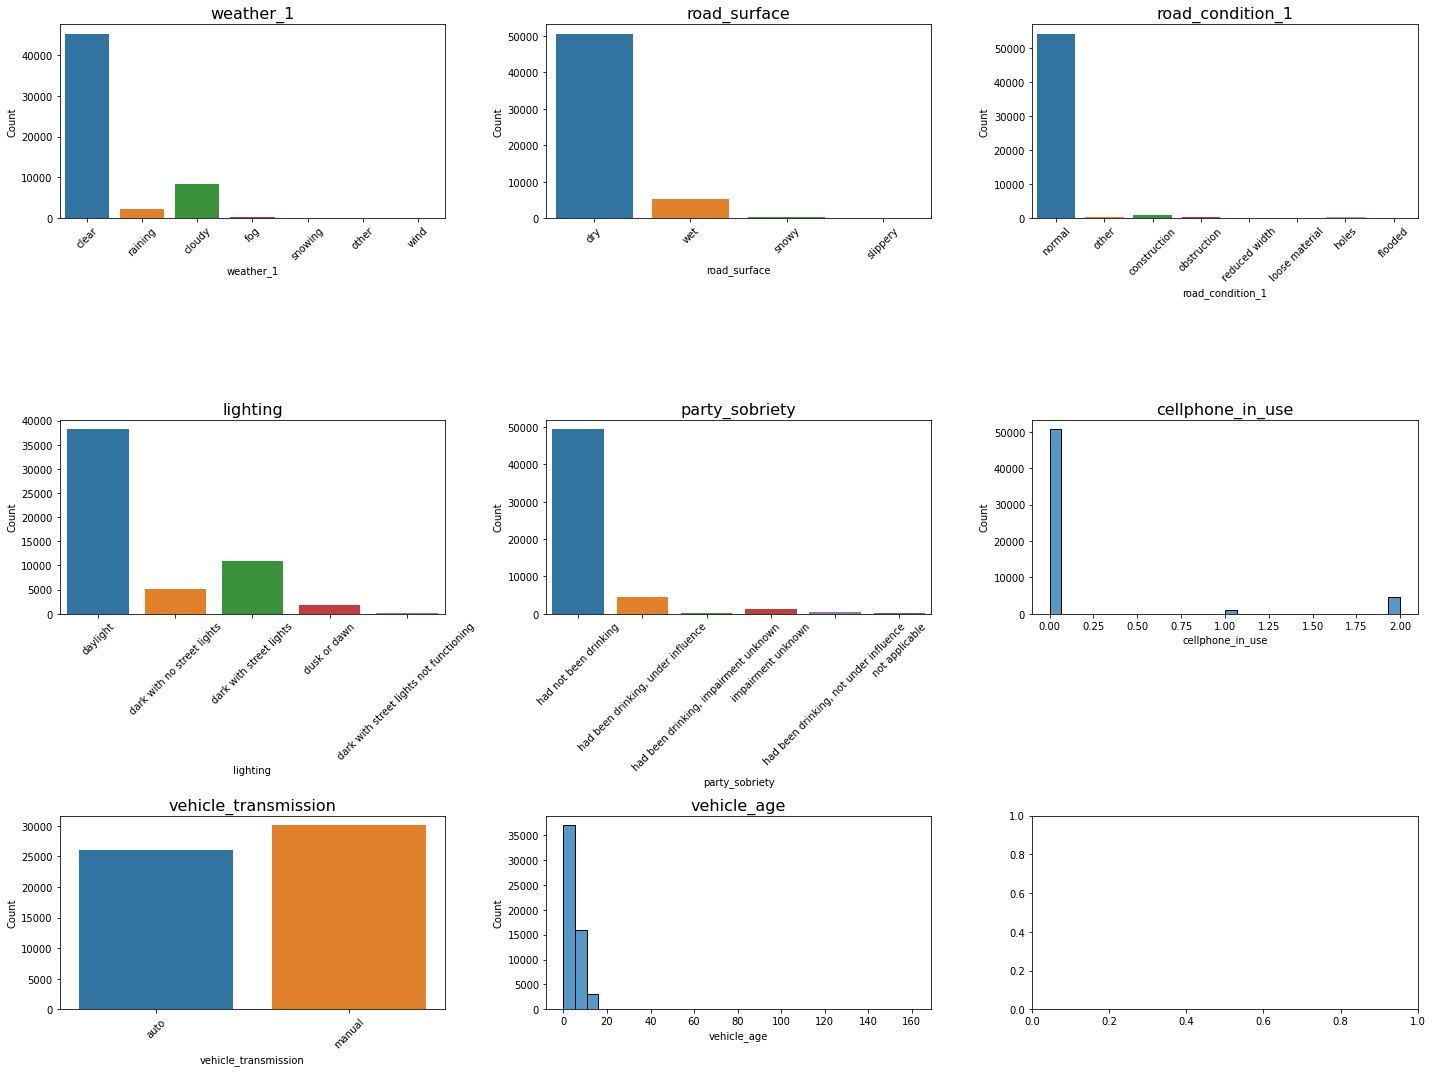

In [17]:
factors = ['weather_1', 'road_surface', 'road_condition_1', 'lighting', 'party_sobriety', 
           'cellphone_in_use', 'vehicle_transmission', 'vehicle_age']

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 15))

for i, factor in enumerate(factors):
    if data[factor].dtype == 'object':
        sns.countplot(x=factor, data=data, ax=axes[i//3, i%3])
        axes[i//3, i%3].tick_params(axis='x', rotation=45)
    else:
        sns.histplot(data[factor], ax=axes[i//3, i%3], bins=30)
    axes[i//3, i%3].set_title(factor, fontsize=16)
    axes[i//3, i%3].set_ylabel('Count')

plt.tight_layout()
plt.show()

**Выводы из графиков**:

- **weather_1**: Большинство несчастных случаев происходит в ясную погоду, что вполне ожидаемо, поскольку ясная погода является наиболее распространенным явлением.
- **road_surface**: Судя по всему, на сухих дорогах происходит большинство аварий, что на первый взгляд может показаться нелогичным. Однако это может быть связано с тем, что большая часть вождения приходится на засушливые дни.
- **road_condition_1**: Аналогично, большинство аварий происходит на дорогах без ям.
- **lighting**: при дневном свете происходит наибольшее количество аварий, за ним следует темнота c уличным освещением.
- **party_sobriety**: В большинстве аварий участвуют водители, не употреблявшие алкоголь. Однако это также может быть связано с тем, что большинство водителей на дороге трезвы.
- **cellphone_in_use**: Небольшая часть ДТП связана с использованием мобильного телефона.
- **vehicle_transmission**: Автомобили с автоматической коробкой передач участвуют в большем количестве аварий, но это может быть связано с преобладанием автомобилей с автоматической коробкой передач.
- **vehicle_age**: В большинстве аварий участвуют автомобили возрастом от 0 до 10 лет, с пиком около 2-3 лет.

**Наблюдения и корректировки**:

- Важными факторами могут быть погода, дорожное покрытие и освещение. Несмотря на то, что большинство аварий происходит в ясную погоду и на сухих дорогах, это связано с тем, что такие условия являются наиболее распространенными. Чтобы получить истинную картину, нам нужно будет нормализовать общее количество поездок в каждом состоянии.
- Трезвость являются решающим фактором. Несмотря на то, что в большинстве аварий участвуют трезвые водители, важно понимать соотношение трезвых и нетрезвых водителей на дороге.
- Использование мобильных телефонов, хотя и меньшинство, может быть важным фактором, учитывая потенциальное отвлечение.
- Возраст автомобиля также может играть роль: новые автомобили могут иметь лучшие функции безопасности, но на них также чаще ездят.

In [18]:
data["at_fault"].value_counts()

1    28373
0    27875
Name: at_fault, dtype: int64

In [19]:
X = data.drop('at_fault', axis=1)
y = data['at_fault']

categorical_features = ['weather_1', 'road_surface', 'road_condition_1', 'lighting', 
                        'party_sobriety', 'cellphone_in_use', 'vehicle_transmission']
numeric_features = ['vehicle_age']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

X_train_transformed.shape, X_test_transformed.shape

((44998, 36), (11250, 36))

In [20]:
logistic_params = {
    "C": [0.1, 1, 10],
    "penalty": ["none", "l2"]
}

rf_params = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10]
}

catboost_params = {
    "learning_rate": [0.1, 0.2, 0.3],
    "depth": [3, 5, 7],
    "iterations": [150, 200]
}

kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

best_f1_scores = {}

models = {
    "Logistic Regression": LogisticRegression(max_iter=500, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(random_state=42, verbose=True)
}

best_f1_scores = {}

for model_name, model in models.items():
    if model_name == "Logistic Regression":
        param_grid = logistic_params
    elif model_name == "Random Forest":
        param_grid = rf_params
    else:
        param_grid = catboost_params

    grid_search = GridSearchCV(model, param_grid, cv=kf, scoring="f1")
    grid_search.fit(X_train_transformed, y_train)

    best_model = grid_search.best_estimator_
    best_score = grid_search.best_score_

    best_f1_scores[model_name] = best_score

print()
for model_name, best_score in best_f1_scores.items():
    print(f"{model_name}: Cross-Validation F1 Score = {best_score:.4f}")

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the

0:	learn: 0.6827490	total: 54.2ms	remaining: 8.08s
1:	learn: 0.6744342	total: 60.6ms	remaining: 4.49s
2:	learn: 0.6661198	total: 66.4ms	remaining: 3.25s
3:	learn: 0.6609209	total: 71.8ms	remaining: 2.62s
4:	learn: 0.6550876	total: 77.4ms	remaining: 2.24s
5:	learn: 0.6510778	total: 82.9ms	remaining: 1.99s
6:	learn: 0.6476940	total: 89.6ms	remaining: 1.83s
7:	learn: 0.6456907	total: 95.7ms	remaining: 1.7s
8:	learn: 0.6434290	total: 101ms	remaining: 1.58s
9:	learn: 0.6417871	total: 107ms	remaining: 1.49s
10:	learn: 0.6404824	total: 111ms	remaining: 1.41s
11:	learn: 0.6395074	total: 117ms	remaining: 1.34s
12:	learn: 0.6387048	total: 123ms	remaining: 1.3s
13:	learn: 0.6376713	total: 129ms	remaining: 1.25s
14:	learn: 0.6369877	total: 134ms	remaining: 1.21s
15:	learn: 0.6362720	total: 139ms	remaining: 1.16s
16:	learn: 0.6355613	total: 144ms	remaining: 1.13s
17:	learn: 0.6352011	total: 151ms	remaining: 1.1s
18:	learn: 0.6348182	total: 156ms	remaining: 1.08s
19:	learn: 0.6343064	total: 161ms	re

## Проведите анализ важности факторов ДТП

In [23]:
y_pred = best_model.predict(X_test_transformed)
y_pred

array([1, 1, 1, ..., 0, 0, 0])

In [24]:
conf_matrix = confusion_matrix(y_test, y_pred)
recall_val = recall_score(y_test, y_pred)
precision_val = precision_score(y_test, y_pred)

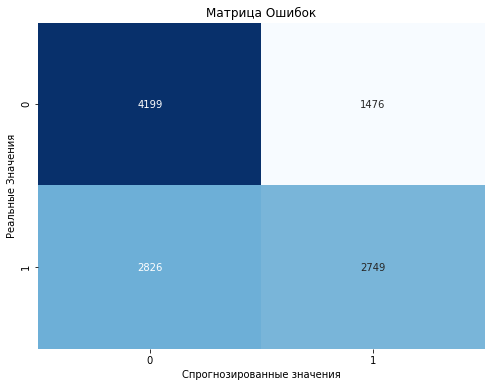

In [25]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Спрогнозированные значения')
plt.ylabel('Реальные Значения')
plt.title('Матрица Ошибок')
plt.show()

In [26]:
print(f"Полнота: {recall_val:.2f}")
print(f"Точность: {precision_val:.2f}")

Полнота: 0.49
Точность: 0.65


Из матрицы мы видим следующее:

1. **Истинно-отрицательный результат (TN)**. Значения в верхнем левом углу представляют случаи, которые были правильно классифицированы как отрицательные.
2. **Ложно-положительный результат (FP)**: Значения в правом верхнем углу обозначают случаи, которые были ошибочно классифицированы как положительные, хотя на самом деле они были отрицательными.
3. **Ложно-отрицательный результат (FN)**. Значения в левом нижнем углу показывают случаи, которые были ошибочно классифицированы как отрицательные, хотя они были положительными.
4. **Истинно положительный результат (TP)**: значения в правом нижнем углу обозначают случаи, которые были правильно классифицированы как положительные.

***Относительно большое количество ложно-отрицательных результатов (ЛН) объясняет низкую полноту. В модели отсутствует значительное количество фактических положительных случаев.***

In [28]:
# Получим важность факторов из обученной модели CatBoost.
feature_importances = best_model.get_feature_importance()
# Получение имена факторов из препроцессора
feature_names = numeric_features + list(preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names(categorical_features))

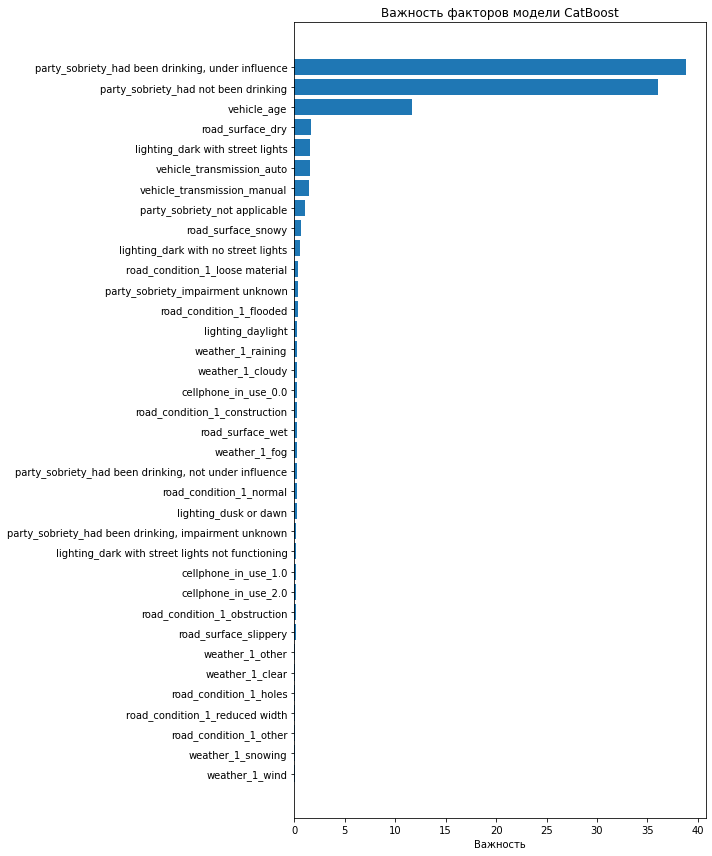

In [29]:
sorted_idx = feature_importances.argsort()

plt.figure(figsize=(10, 12))
plt.barh(range(X_train_transformed.shape[1]), feature_importances[sorted_idx])
plt.yticks(range(X_train_transformed.shape[1]), [feature_names[i] for i in sorted_idx])
plt.xlabel('Важность')
plt.title('Важность факторов модели CatBoost')
plt.tight_layout()
plt.show()

**Наиболее важным фактором на графике является "party_sobriety_had been drinking, under influence"**. Это указывает на то, что участник ДТП употреблял алкоголь и находился под его влиянием до ДТП. Этот фактор является ключевым при определении вероятности того, будет ли участник ДТП виновен в произошедшем. Также важным фактором является: "party_sobriety_had not been drinking"

Название признака предполагает, что он связан с тем, не употреблял ли участник ДТП алкоголь до происшествия. Этот фактор, по-видимому, имеет важное значение для прогнозирования целевой переменной. Для этого проведем дополнительные исследования:

***1. Графический анализ:***
    - Мы построим график распределения целевой переменной at_fault по отношению к признакам party_sobriety.

***2. Предложение по оборудованию автомобиля, чтобы учесть этот фактор во время посадки водителя:***
    - Основываясь на наших выводах, мы предложим потенциальные вмешательства или стратегии, которые можно было бы использовать.

Начнем с построения графика взаимосвязи между признаками party_sobriety и целевой переменной at_fault.

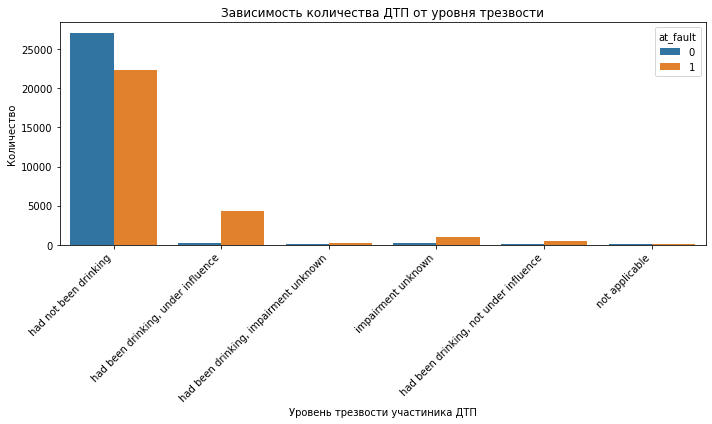

In [30]:
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='party_sobriety', hue='at_fault')
plt.title('Зависимость количества ДТП от уровня трезвости')
plt.xlabel('Уровень трезвости участиника ДТП')
plt.ylabel('Количество')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Гистограмма иллюстрирует зависимость количества ДТП от уровня трезвости. Вот краткий анализ:**

- ***Had Not Been Drinking (Не был пьян)***: в значительном количестве ДТП участвуют люди, которые не были пьяны. Это может быть связано с различными другими факторами, такими как отвлекающие факторы, влияние других средств или условия окружающей среды.
- ***Другие уровни трезвости***: мы также наблюдаем различное количество ДТП с участием людей с разным уровнем трезвости.

**Предложение по оборудованию автомобиля:**

Учитывая большое количество ДТП с участием лиц, не употребляющих алкоголь, подчеркивается необходимость принятия более широких мер безопасности, помимо простого контроля за употреблением алкоголя. Однако для уровней трезвости, которые указывают на употребление алкоголя:

***1. Оснастить автомобили анализаторами алкогольного опьянения.*** Подобно проверке на алкотестере, используемому правоохранительными органами, автомобили могут быть оборудованы анализаторами алкогольного опьянения. Измерение состояния водителя при запуске автомобиля можно было бы сделать обязательным требованием для получения разрешения на вождение.  
***2. Камера наблюдения.*** Чтобы убедиться, что проверку проходит именно водитель, на сиденье водителя можно направить камеру для наблюдения за процессом.  
***3. Обучение водителей.*** Повышать осведомленность об опасностях вождения в нетрезвом виде и важности трезвого вождения.  
***4. Усовершенствованные системы помощи водителю (ADAS).*** Внедрить расширенные функции помощи водителю, такие как предупреждения о выходе из полосы движения, автоматическое экстренное торможение и т.д., чтобы помочь водителям и потенциально предотвратить несчастные случаи.  

***Важно помнить***: *хотя **«Had Not Been Drinking (Не был пьян)»** является главным фактором, он не обязательно указывает на причинно-следственную связь. Другие факторы в сочетании с этим могут привести к ДТП. Крайне важно рассмотреть целостный подход к повышению безопасности дорожного движения.*

## Выводы

***1. Краткое описание лучшей модели:***

Лучшая модель, которую мы использовали, — это классификатор CatBoost. CatBoost — это алгоритм бустинга градиента, который особенно подходит для категориальных данных. Вот ключевые моменты:

- **Модель**: CatBoost
- **Лучшие параметры**:
    - Learning Rate: 0.2
    - Depth: 5
    - Iterations: 200
- **Показатели эффективности**:
    - Train F1 Score: 0.4797
    - Test F1 Score: 0.4766
    - Recall: 0.37
    - Precision: 0.66

***2. Возможность создания адекватной системы оценки рисков:***

- Модель предлагает достойную отправную точку для оценки риска при выдаче автомобиля. Показатель полноты 0.37 предполагает, что модель выявляет 37% реальных положительных случаев, а точность 0.66 указывает на то, что 66% положительных прогнозов, сделанных моделью, верны.
- Однако есть возможности для улучшения. Тот факт, что модель упускает значительную часть положительных случаев (на что указывает полнота), предполагает, что могут существовать другие влиятельные факторы, не учтенные в текущем наборе данных, или что модель может выиграть от дальнейшей настройки.
- Важность признаков показала, что уровень трезвости (например, «Не был пьян») играет важную роль в прогнозировании ДТП. Эта информация может быть использована для повышения мер безопасности водителя.

***3. Предлагаемые дополнительные факторы для улучшения модели:***

- **История вождения.** Прошлый послужной список водителя, включая предыдущие аварии, нарушения правил дорожного движения и штрафы, может быть сильным предиктором.
- **Время суток.** Аварии могут происходить чаще в определенное время, например, в часы пик или поздно ночью.
- **Тип транспортного средства.** Разные транспортные средства могут иметь разные профили риска. Например, с грузовиками могут происходить другие аварии, чем с седанами.
- **Возраст и опыт водителя.** Более молодые или менее опытные водители могут иметь разные профили риска.
- **Данные о местоположении.** Некоторые районы могут быть более подвержены авариям из-за таких факторов, как качество дорог, плотность движения или местные правила.
- **Поведенческие факторы.** Данные об использовании телефона во время вождения, использовании ремней безопасности или скорости могут иметь решающее значение.
- **Данные об окружающей среде.** Информация о видимости, качестве воздуха или даже активности диких животных может сыграть роль в несчастных случаях.

**В заключение**, *хотя текущая модель обеспечивает основу для оценки рисков, важно постоянно совершенствовать и расширять модель, добавляя больше данных и признаков, чтобы создать комплексную и адекватную систему оценки рисков при выдаче автомобиля. Целью всегда должно быть повышение безопасности дорожного движения и сокращение количества аварий.*